# AIClinician core code
Builds 500 models using MIMIC-III training data  
Records best candidate models along the way from off-policy policy evaluation on MIMIC-III validation data  
Tests the best model on eRI data  


TAKES:  
        - MIMICtable = m*59 table with raw values from MIMIC  
        - eICUtable = n*56 table with raw values from eICU  
        

GENERATES:  
        - MIMICraw = MIMIC RAW DATA m*47 array with columns in right order  
        - MIMICzs = MIMIC ZSCORED m*47 array with columns in right order, matching MIMICraw  
        - eICUraw = eICU RAW DATA n*47 array with columns in right order, matching MIMICraw  
        - eICUzs = eICU ZSCORED n*47 array with columns in right order, matching MIMICraw  
        - recqvi = summary statistics of all 500 models  
        - idxs = state membership of MIMIC test records, for all 500 models  
        - OA = optimal policy, for all 500 models  
        - allpols = detailed data about the best candidate models  


In [1]:
import pandas as pd
import numpy as np
exportdir='/data/localhost/taufiq/export-dir/'

In [2]:
import logging
logging.basicConfig(filename='core.log', level=logging.INFO)

In [3]:
############################  IMPORT DATA   #####################################
MIMICtable = pd.read_csv(exportdir + 'MIMICtable.csv')
MIMICtable.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,mechvent,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_4hourly,output_total,output_4hourly,cumulated_balance
0,1.0,3.0,7.245400e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.653782,222.499997,0.0,0.0,6297.0,30.0,9090.0,4305.0,-2793.0
1,2.0,3.0,7.245414e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.710438,207.499997,0.0,0.0,6347.0,50.0,13060.0,3970.0,-6713.0
2,3.0,3.0,7.245428e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.748397,207.499997,0.0,0.0,6397.0,50.0,16260.0,3200.0,-9863.0
3,4.0,3.0,7.245443e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.615226,207.499997,0.0,0.0,6447.0,50.0,18910.0,2650.0,-12463.0
4,5.0,3.0,7.245457e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.749047,165.573772,0.0,0.0,6477.0,30.0,21180.0,2270.0,-14703.0


In [4]:
############################  MODEL PARAMETERS   #####################################
nr_reps=50               # nr of repetitions (total nr models)
nclustering=32            # how many times we do clustering (best solution will be chosen)
prop=0.25                 # proportion of the data we sample for clustering
gamma=0.99                # gamma
transthres=5              # threshold for pruning the transition matrix
polkeep=1                 # count of saved policies
ncl=750                   # nr of states
nra=5                     # nr of actions (2 to 10)
ncv=5                     # nr of crossvalidation runs (each is 80% training / 20% test)
OA=pd.DataFrame(index = range(1,ncl+3), columns = range(nr_reps)) # record of optimal actions
recqvi=pd.DataFrame() # saves data about each model (1 row per model)
allpols=pd.DataFrame()

In [5]:
#################   Convert training data and compute conversion factors    ######################

# all 47 columns of interest
colbin = ['gender','mechvent','max_dose_vaso','re_admission']
colnorm=['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',\
    'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',\
    'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',\
    'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index','PaO2_FiO2','cumulated_balance']
collog=['SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR','input_total','input_4hourly','output_total','output_4hourly']

MIMICraw = MIMICtable[colbin+colnorm+collog].copy()

for col in MIMICraw:
    if col in colbin:
        MIMICraw[col] = MIMICraw[col] - 0.5
    elif col in colnorm:
        cmu = MIMICraw[col].mean()
        csigma = MIMICraw[col].std()
        MIMICraw[col] = (MIMICraw[col] - cmu)/csigma
    else:
        log_values = np.log(0.1 + MIMICraw[col])
        dmu = log_values.mean()
        dsigma = log_values.std()
        MIMICraw[col] = (log_values - dmu)/dsigma                 

In [6]:
MIMICraw['re_admission'] = np.log(MIMICraw['re_admission'] + 0.6)
MIMICraw['input_4hourly'] = 2*MIMICraw['input_4hourly']

In [7]:
MIMICraw.head()

,gender,mechvent,max_dose_vaso,re_admission,age,Weight_kg,GCS,HR,SysBP,MeanBP,...,BUN,Creatinine,SGOT,SGPT,Total_bili,INR,input_total,input_4hourly,output_total,output_4hourly
0,-0.5,-0.5,-0.5,-2.302585,-1.051213,1.827456,-0.952846,-0.523975,-0.064338,0.296909,...,0.211224,0.735987,0.250377,-0.38494,3.417208,0.302317,0.509150,0.376513,0.074017,0.612008
1,-0.5,-0.5,-0.5,-2.302585,-1.051213,-0.135125,-0.952846,-0.445075,-0.441478,0.000394,...,-1.200304,-0.730676,-0.171064,-0.38494,1.549167,-0.961687,0.511497,0.655827,0.182853,0.590004
2,-0.5,-0.5,-0.5,-2.302585,-1.051213,-0.135125,-0.899877,-0.521990,-0.806252,-0.147864,...,-1.200304,-0.730676,-0.171064,-0.38494,1.549167,-0.245226,0.513825,0.655827,0.248674,0.531440
3,-0.5,-0.5,-0.5,-2.302585,-1.051213,-0.135125,-0.635036,-0.705596,0.059314,1.334712,...,-1.200304,-0.730676,-0.171064,-0.38494,1.549167,-0.961687,0.516135,0.655827,0.294020,0.480217
4,-0.5,-0.5,-0.5,-2.302585,-1.051213,-0.135125,0.381956,0.690797,0.534139,1.527447,...,-1.200304,-0.730676,-0.171064,-0.38494,1.549167,-0.961687,0.517513,0.376513,0.328069,0.438177


# Create Actions

In [8]:
logging.info('Creating action bins')

from sklearn.cluster import KMeans
from scipy.stats import rankdata

nact = nra**2
input_4hourly_nonzero = MIMICtable.loc[MIMICtable['input_4hourly']>0, 'input_4hourly']
iol_ranked = rankdata(input_4hourly_nonzero)/len(input_4hourly_nonzero) # excludes zero fluid (will be action 1)
iof = np.floor((iol_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
io = np.ones(len(MIMICtable)) # array of ones, by default
io[MIMICtable['input_4hourly']>0] = iof + 1 # where more than zero fluid given: save actual action
vc = MIMICtable['max_dose_vaso'].copy()
vc_nonzero = MIMICtable.loc[MIMICtable['max_dose_vaso']!=0, 'max_dose_vaso']
vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero)
vcf = np.floor((vc_ranked + 0.2499999999)*4) # converts to 4 bins
vcf[vcf==0] = 1
vc[vc!=0] = vcf + 1
vc[vc==0] = 1
# median dose of drug in all bins
ma1 = [MIMICtable.loc[io==1, 'input_4hourly'].median(), MIMICtable.loc[io==2, 'input_4hourly'].median(), MIMICtable.loc[io==3, 'input_4hourly'].median(), MIMICtable.loc[io==4, 'input_4hourly'].median(), MIMICtable.loc[io==5, 'input_4hourly'].median()]
ma2 = [MIMICtable.loc[vc==1, 'max_dose_vaso'].median(), MIMICtable.loc[vc==2, 'max_dose_vaso'].median(), MIMICtable.loc[vc==3, 'max_dose_vaso'].median(), MIMICtable.loc[vc==4, 'max_dose_vaso'].median(), MIMICtable.loc[vc==5, 'max_dose_vaso'].median()]
med = pd.DataFrame(data={'IV':io, 'VC': vc})
med = med.astype({'IV': 'int32', 'VC': 'int32'})
uniqueValues = med.drop_duplicates().reset_index(drop=True)
uniqueValueDoses = pd.DataFrame()
for index, row in uniqueValues.iterrows():
    uniqueValueDoses.at[index, 'IV'], uniqueValueDoses.at[index, 'VC'] = ma1[row['IV']-1], ma2[row['VC']-1]

actionbloc = pd.DataFrame()
for index, row in med.iterrows():
    actionbloc.at[index, 'action_bloc'] = uniqueValues.loc[(uniqueValues['IV'] == row['IV']) & (uniqueValues['VC'] == row['VC'])].index.values[0]+1
actionbloc = actionbloc.astype({'action_bloc':'int32'})

logging.info('Action bins created')

# Define policy evaluation and iteration functions

In [9]:
def mdp_computePpolicyPRpolicy(P, R, policy):
    S = len(P)
    Ppolicy = np.zeros((S,S))
    PRpolicy = np.zeros(S)
    A = len(P[0][0])
    for a in range(A):
        ind = policy==a
        if ind.sum() > 0:
            for j in range(S):
                if ind[j]:
                    for i in range(S):
                            Ppolicy[j][i] = P[j][i][a]
                    PRpolicy[j] = R[j][a]
    return Ppolicy, PRpolicy

In [10]:
def mdp_eval_policy_matrix(P,R,discount,policy):
    S = len(P)
    Ppolicy, PRpolicy = mdp_computePpolicyPRpolicy(P, R, policy)
    Vpolicy = np.matmul(np.linalg.inv(np.identity(S) - discount*Ppolicy), PRpolicy)
    return Vpolicy

In [11]:
def mdp_bellman_operator_with_Q(P, PR, discount, Vprev):
    A = len(P[0][0])
    S = len(P)
    Q = np.zeros((S,A))
    for a in range(A):
        for i in range(S):
            next_step_reward = 0
            for j in range(S):
                next_step_reward += P[i][j][a]*Vprev[j]
            Q[i][a] = PR[i][a] + discount*next_step_reward
    V = Q.max(axis=1)
    policy = Q.argmax(axis=1)
    return V, Q, policy

In [12]:
def mdp_policy_iteration_with_Q(P, R, discount, policy0, max_iter=1000):
    i = 0
    policy = policy0
    is_done = False
    while not is_done:
        i += 1
        V = mdp_eval_policy_matrix(P,R,discount,policy)
        nil, Q, policy_next = mdp_bellman_operator_with_Q(P,R,discount,V)
        n_different = (policy_next != policy).sum()
        if n_different == 0 or i == max_iter or (i > 20 and n_different <= 5):
            is_done = True
        else:
            policy = policy_next
    return V, policy, i, Q

In [13]:
def OffpolicyQlearning150816( qldata , gamma, alpha, numtraces):
    sumQ = np.zeros(numtraces)
    Q = np.zeros((ncl, nact))
    maxavgQ = 1
    modu = 100
    first_step = qldata[qldata['blocs'] == 1].index
    nrepi = len(first_step)
    j = 0
    done = False
    while j < numtraces and not done:
        i = first_step[np.random.randint(nrepi-1)] # pick one episode randomly (not the last one!)
        trace = pd.DataFrame()
        
        while qldata.at[i+1, 'blocs'] != 1:
            s_a_r = {'S1': qldata.at[i+1, 'idx'],\
                     'a1': qldata.at[i+1, 'actionbloc'],\
                     'r1': qldata.at[i+1, 'reward']}
            trace = trace.append(s_a_r, ignore_index=True)
            i += 1
            
        tracelength = len(trace)
        return_t = trace.at[tracelength-1, 'r1'] # get last reward as return for penultimate state and action.
        for t in range(tracelength-2, -1, -1):
            s, a = int(trace.at[t, 'S1']), int(trace.at[t, 'a1']-1)
            Q[s][a] = (1-alpha)*Q[s][a] + alpha*return_t
            return_t = return_t*gamma + trace.at[t, 'r1']

        sumQ[j] = Q.sum()
        j = j + 1

        if j > 0 and (j % modu*500) == 0:
            s = sumQ[j-modu*500:].mean()
            if maxavgQ==0:
                d = np.nan
            else:
                d = (s - maxavgQ)/maxavgQ
            if abs(d)<0.001:
                done = True
            maxavgQ = s
    return Q, sumQ
    

In [14]:
def offpolicy_eval_tdlearning( qldata,physpol, gamma ,num_iter):
    ncl = len(physpol)-2
    bootql = np.zeros(num_iter)
    patients = qldata['pt_id'].unique()
    prop = 5000/len(patients) # 5000 patients of the samples are used
    prop = min(prop, 0.75) # max possible value is 0.75 (75% of the samples are used)
    a = qldata.loc[qldata['blocs']==1, 'idx']
    d = np.zeros(ncl) # initial state distribution
    for i in range(ncl):
        d[i] = (a==i).sum()
    for i in range(num_iter):
        chosen = np.floor(np.random.rand(len(patients)) + prop)
        q = qldata.loc[qldata['pt_id'].isin(patients[chosen==1])].reset_index()
        Qoff, _ = OffpolicyQlearning150816( q , gamma, 0.1, 30000)
    
        V = np.zeros((ncl, nact))
        for k in range(ncl):
            for l in range(nact):
                V[k][l] = physpol[k][l]*Qoff[k][l]

        Vs = V.sum(axis=1)
        bootql[i] = (Vs*d).sum()/d.sum()
    
    return bootql
        

In [15]:
def offpolicy_eval_wis(qldata,gamma ,num_iter):
    bootwis = np.zeros(num_iter)
    patients = qldata['pt_id'].unique()
    prop = 25000/len(patients) # 25000 patients of the samples are used
    prop = min(prop, 0.75) # max possible value is 0.75 (75% of the samples are used)
    for jj in range(num_iter):
        chosen = np.floor(np.random.rand(len(patients)) + prop)
        q = qldata.loc[qldata['pt_id'].isin(patients[chosen==1])].reset_index()
        fence_posts = q.loc[q['blocs']==1].index
        num_of_trials = len(fence_posts)
        individual_trial_estimators = np.empty(num_of_trials)
        individual_trial_estimators[:] = np.nan
        rho_array = np.empty(num_of_trials)
        rho_array[:] = np.nan
        c = 0
        for i in range(num_of_trials - 1):
            rho = 1
            for t in range(fence_posts[i], fence_posts[i+1]-1):
                if q.at[t,'softpi(s,a)'] == 0:
                    rho = np.nan
                else:
                    rho = rho*q.at[t,'softb(s,a)']/q.at[t,'softpi(s,a)']
            if rho > 0:
                c += 1
            rho_array[i] = rho
        normalization = np.nansum(rho_array)
        for i in range(num_of_trials - 1):
            current_trial_estimator = 0
            rho = 1
            discount = 1/gamma
            for t in range(fence_posts[i], fence_posts[i+1]-1):
                if q.at[t,'softpi(s,a)'] == 0:
                    rho = np.nan
                else:
                    rho = rho*q.at[t,'softb(s,a)']/q.at[t,'softpi(s,a)']
                discount  = discount*gamma
                current_trial_estimator = current_trial_estimator + discount * q.at[t+1, 'reward']
            individual_trial_estimators[i] =  current_trial_estimator*rho
        bootwis[jj] = np.nansum(individual_trial_estimators)/normalization
    individual_trial_estimators = (individual_trial_estimators/rho_array)[rho_array != np.nan]
    return bootwis

In [16]:
def offpolicy_multiple_eval_010518(qldata, physpol, gamma, iter_ql, iter_wis):
    bootql = offpolicy_eval_tdlearning( qldata,physpol, gamma ,iter_ql)
    bootwis = offpolicy_eval_wis(qldata,gamma ,iter_wis)
    return bootql, bootwis

# Main loop over all models

In [ ]:
icuuniqueids = MIMICtable['icustay_id'].unique()

for model in range(nr_reps):
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = MIMICraw.loc[MIMICtable['icustay_id'].isin(trainidx)]
    Xtestmimic = MIMICraw[MIMICtable['icustay_id'].isin(testidx)]
    blocs = MIMICtable.loc[MIMICtable['icustay_id'].isin(trainidx), 'bloc']
    bloctestmimic = MIMICtable.loc[MIMICtable['icustay_id'].isin(testidx), 'bloc']
    ptid = MIMICtable.loc[MIMICtable['icustay_id'].isin(trainidx), 'icustay_id']
    ptidtestmimic = MIMICtable.loc[MIMICtable['icustay_id'].isin(testidx), 'icustay_id']
    Y90 = MIMICtable.loc[MIMICtable['icustay_id'].isin(trainidx), 'mortality_90d']
    
    logging.info('########################   MODEL NUMBER : '+ str(model))
    
    #######   find best clustering solution (lowest intracluster variability)  ####################
    logging.info('####  CLUSTERING  ####')
    sample = X[np.floor(np.random.rand(len(X))+prop) == 1]
    kmeans = KMeans(n_clusters=ncl, random_state=0).fit(sample)
    idx = kmeans.predict(X)
    
    actionbloctrain = actionbloc.loc[MIMICtable['icustay_id'].isin(trainidx)]
    
    logging.info('####  CREATE qldata_abs_states  ####')
    reward = 100*(Y90==0) - 100*(Y90==1)
    qldata = pd.DataFrame({'blocs': blocs.values, 'idx': idx, 'actionbloc': actionbloctrain['action_bloc'].values, 'Y90': Y90.values, 'reward': reward.values, 'pt_id': ptid.values})
    absorbing_states = [ncl, ncl+1] # absorbing states numbers
    qldata_abs_states = pd.DataFrame()
    for index, row in qldata.iterrows():
        qldata_abs_states = qldata_abs_states.append(row)
        if (index < len(qldata)-1 and qldata.at[index+1, 'blocs'] == 1) or index == len(qldata)-1:
            qldata_abs_states = qldata_abs_states.append({'blocs': qldata.at[index, 'blocs']+1, 'idx': absorbing_states[int(row['Y90'])], 'actionbloc': 0, 'Y90':row['Y90'], 'reward': row['reward'], 'pt_id': row['pt_id']}, ignore_index=True)
    
    logging.info('####  CREATE TRANSITION MATRIX T(S'',S,A) ####')
    transitionr = np.zeros((ncl+2, ncl+2, nact))
    sums = np.zeros((ncl+2, nact))
    
    for index, row in qldata.iterrows():
        if index < len(qldata)-1 and qldata.at[index+1, 'blocs'] != 1:
            S0, S1, ac_id = int(qldata.at[index, 'idx']), int(qldata.at[index+1, 'idx']), int(qldata.at[index, 'actionbloc'])
            transitionr[S1-1][S0-1][ac_id-1] = transitionr[S1-1][S0-1][ac_id-1]+1
            sums[S0-1][ac_id-1] = sums[S0-1][ac_id-1] + 1
            
    sums[sums<=transthres] = 0 # delete rare transitions (those seen less than 5 times = bottom 50%!!) IQR = 2-17
    for i in range(ncl+2):
        for j in range(nact):
            if sums[i][j] == 0:
                for k in range(ncl+2):
                    transitionr[k][i][j] = 0
            else:
                for k in range(ncl+2):
                    transitionr[k][i][j]=transitionr[k][i][j]/sums[i][j]
    transitionr[pd.isna(transitionr)] = 0
    transitionr[transitionr==np.nan] = 0
    
    physpol = (sums.T/((sums.sum(axis=1)==0) + (sums.sum(axis=1)))).T # physicians policy: what action was chosen in each state
    
    logging.info('####  CREATE TRANSITION MATRIX T(S,S'',A)  ####')
    transitionr2 = np.zeros((ncl+2, ncl+2, nact))
    sums = np.zeros((ncl+2, nact))
    
    for index, row in qldata_abs_states.iterrows():
        if index < len(qldata_abs_states)-1 and qldata_abs_states.at[index+1, 'blocs'] != 1:
            S0, S1, ac_id = int(qldata_abs_states.at[index, 'idx']), int(qldata_abs_states.at[index+1, 'idx']), int(qldata_abs_states.at[index, 'actionbloc'])
            transitionr2[S0-1][S1-1][ac_id-1] = transitionr2[S0-1][S1-1][ac_id-1]+1
            sums[S0-1][ac_id-1] = sums[S0-1][ac_id-1] + 1
    
    sums[sums<=transthres] = 0
    for i in range(ncl+2):
        for j in range(nact):
            if sums[i][j] == 0:
                for k in range(ncl+2):
                    transitionr2[i][k][j] = 0
            else:
                for k in range(ncl+2):
                    transitionr2[i][k][j]=transitionr2[i][k][j]/sums[i][j]
    transitionr2[pd.isna(transitionr2)] = 0
    transitionr2[transitionr2==np.nan] = 0
    
    logging.info('####  CREATE REWARD MATRIX  R(S,A) ####')
    # CF sutton& barto bottom 1998 page 106. i compute R(S,A) from R(S'SA) and T(S'SA)
    r3 = np.zeros((ncl+2, ncl+2, nact))
    r3[ncl] = -100
    r3[ncl+1] = 100
    R = (transitionr*r3).sum(axis=1)
    
    logging.info('####   POLICY ITERATION   ####')
    _,_,_,Qon = mdp_policy_iteration_with_Q(transitionr2, R, gamma, np.ones(ncl+2))
    OptimalAction = Qon.argmax(axis=1) # deterministic
    OA[model] = OptimalAction # save optimal actions
    
    logging.info('#### OFF-POLICY EVALUATION - MIMIC TRAIN SET ####')
    # add pi(s,a) and b(s,a)
    p = 0.01
    softpi = physpol.copy()
    for i in range(ncl):
        zeros = softpi[i]==0
        if zeros.sum() > 0 and (~zeros).sum() > 0:
            z = p/zeros.sum()
            softpi[i][zeros] = z
            nz = p/(~zeros).sum()
            softpi[i][~zeros] = softpi[i][~zeros] - nz
    
    softb = np.zeros((ncl+2, nact))+p/(nact-1)
    for i in range(ncl):
        softb[i][OptimalAction[i]] = 1-p
    
    non_absorbing_s = qldata_abs_states['idx']<ncl
    for index, row in qldata_abs_states.iterrows():
        if row['idx'] < ncl:
            qldata_abs_states.at[index,'softpi(s,a)'] = softpi[int(row['idx'])][int(row['actionbloc'])-1]
            qldata_abs_states.at[index,'softb(s,a)'] = softb[int(row['idx'])][int(row['actionbloc'])-1]
            qldata_abs_states.at[index,'optimal_action'] = OptimalAction[int(row['idx'])]
            
    bootql, bootwis = offpolicy_multiple_eval_010518(qldata_abs_states,physpol, 0.99,6,750)
    recqvi.at[model, 'model'] = model
    recqvi.at[model, 'bootql_mean'] = np.nanmean(bootql)
    recqvi.at[model, 'bootql_99_quantile'] = np.quantile(bootql, 0.99)
    recqvi.at[model, 'bootwis_mean'] = np.nanmean(bootwis)
    recqvi.at[model, 'bootwis_99_quantile'] = np.quantile(bootwis, 0.99)
    qldata_train = qldata_abs_states.copy()
    
    logging.info('#### OFF-POLICY EVALUATION - MIMIC TEST SET ####')
    idxtest = kmeans.predict(Xtestmimic)
    
    actionbloctest = actionbloc.loc[MIMICtable['icustay_id'].isin(testidx)]
    Y90test = MIMICtable.loc[MIMICtable['icustay_id'].isin(testidx), 'mortality_90d']
    rewardtest = 100*(Y90test==0) - 100*(Y90test==1)
    qldata = pd.DataFrame({'blocs': bloctestmimic.values, 'idx': idxtest, 'actionbloc': actionbloctest['action_bloc'].values, 'Y90': Y90test.values, 'reward': rewardtest.values, 'pt_id': ptidtestmimic.values})
    
    qldata_abs_states = pd.DataFrame()
    for index, row in qldata.iterrows():
        qldata_abs_states = qldata_abs_states.append(row)
        if (index < len(qldata)-1 and qldata.at[index+1, 'blocs'] == 1) or index == len(qldata)-1:
            qldata_abs_states = qldata_abs_states.append({'blocs': qldata.at[index, 'blocs']+1, 'idx': absorbing_states[int(row['Y90'])], 'actionbloc': 0, 'Y90':row['Y90'], 'reward': row['reward'], 'pt_id': row['pt_id']}, ignore_index=True)

    for index, row in qldata_abs_states.iterrows():
        if row['idx'] < ncl:
            qldata_abs_states.at[index,'softpi(s,a)'] = softpi[int(row['idx'])][int(row['actionbloc'])-1]
            qldata_abs_states.at[index,'softb(s,a)'] = softb[int(row['idx'])][int(row['actionbloc'])-1]
            qldata_abs_states.at[index,'optimal_action'] = OptimalAction[int(row['idx'])]
            
    bootmimictestql, bootmimictestwis = offpolicy_multiple_eval_010518(qldata_abs_states,physpol, 0.99,6,2000)
    recqvi.at[model, 'bootmimictestql_mean'] = np.nanmean(bootmimictestql)
    recqvi.at[model, 'bootmimictestql_99_quantile'] = np.quantile(bootmimictestql, 0.99)
    recqvi.at[model, 'bootmimictestwis_mean'] = np.nanmean(bootmimictestwis)
    recqvi.at[model, 'bootmimictestwis_99_quantile'] = np.quantile(bootmimictestwis, 0.99)
    recqvi.at[model, 'bootmimictestwis_1%_LB'] = np.quantile(bootmimictestwis, 0.01)
    recqvi.at[model, 'bootmimictestwis_5%_LB'] = np.quantile(bootmimictestwis, 0.05)
    qldata_test = qldata_abs_states.copy()

    
    if recqvi.at[model, 'bootmimictestwis_5%_LB'] > 0:
        logging.info('####   GOOD MODEL FOUND - SAVING IT   ####')
        poldata = {'model': model,\
                   'Qon': Qon,\
                   'physpol': physpol,\
                   'transitionr': transitionr,\
                   'transitionr2': transitionr2,\
                   'R': R,\
                   'kmeans': kmeans,\
                   'train': trainidx,\
                   'qldata_train': qldata_train,\
                   'qldata_test': qldata_test}
        allpols = allpols.append(poldata, ignore_index=True)

# Identifies Best Model Here

In [25]:
best_model = recqvi['bootmimictestwis_5%_LB'].values.argmax()

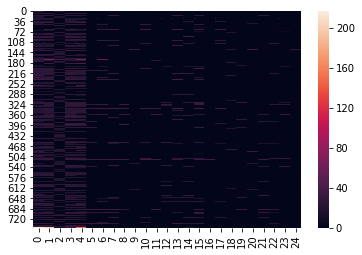

In [41]:
import seaborn as sns
Qon = allpols.loc[allpols['model']==best_model,'Qon'].values[0]
ax = sns.heatmap(Qon)

In [27]:
best_model

47